## Configuration

Specify the path to your CSV file and whether it's a full or minimal export.

In [11]:
# Configuration Parameters
FOLDER_PATH = r"results_20251222_111450"  # Update this path
CSV_FILE_PATH = rf"{FOLDER_PATH}\all_games_minimal.csv"  # Update this path
CSV_TYPE = "minimal"  # Options: "full" or "minimal"
INCLUDE_OT_GAMES = False  # Set to False to exclude overtime games

CSV_INFO_FILE_PATH = rf"{FOLDER_PATH}\simulation_summary.json"  # Update this path

## Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import json

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully")

Libraries imported successfully


## Load and Prepare Data

In [13]:
# Load CSV data
df = pd.read_csv(CSV_FILE_PATH, sep=';')

print(f"Loaded {len(df)} rows from {CSV_FILE_PATH}")
print(f"\nNumber of unique games: {df['game_id'].nunique()}")

print(f"\nColumns in the dataset:")
for col in df.columns:
    print(f"- {col}")

# Load simulation summary information
with open(CSV_INFO_FILE_PATH, 'r') as f:
    sim_summary = json.load(f)

Loaded 2639161 rows from results_20251222_111450\all_games_minimal.csv

Number of unique games: 100000

Columns in the dataset:
- round_number
- is_t1_winner
- is_t1_ct
- is_ot
- outcome_reason_code
- outcome_bomb_planted
- t1_score_start
- t1_score_end
- t1_spent
- t1_earned
- t1_funds_start
- t1_rs_eq
- t1_fte_eq
- t1_re_eq
- t1_survivors
- t1_consecutive_losses
- t1_consecutive_wins
- t1_loss_bonus_level
- t2_score_start
- t2_score_end
- t2_spent
- t2_earned
- t2_funds_start
- t2_rs_eq
- t2_fte_eq
- t2_re_eq
- t2_survivors
- t2_consecutive_losses
- t2_consecutive_wins
- t2_loss_bonus_level
- game_id


## Filter Data

In [14]:

# Apply OT filter
if not INCLUDE_OT_GAMES:
    df_filtered = df[df['is_ot'] == False].copy()
    print(f"Excluded OT games. Total rows: {len(df_filtered)} ({len(df_filtered)/len(df)*100:.1f}% of original)")
else:
    df_filtered = df.copy()
    print(f"Including all games (with OT). Total rows: {len(df_filtered)}")

print(f"\nGames after filter: {df_filtered['game_id'].nunique()}")
print(f"Rounds with OT: {df_filtered['is_ot'].sum()}")
print(f"Rounds without OT: {(~df_filtered['is_ot']).sum()}")

Excluded OT games. Total rows: 2292872 (86.9% of original)

Games after filter: 90641
Rounds with OT: 0
Rounds without OT: 2292872


## Data Summary Statistics

In [15]:
# Summary statistics
print("=" * 60)
print("ECONOMIC METRICS SUMMARY")
print("=" * 60)



# Team 1 statistics
print(f"\nTeam 1: {sim_summary['simulation_config']['team1_strategy']}")
print(f"  Avg Starting Funds: ${df_filtered['t1_funds_start'].mean():.2f}")
print(f"  Avg FTE Equipment: ${df_filtered['t1_fte_eq'].mean():.2f}")
print(f"  Avg Spent per Round: ${df_filtered['t1_spent'].mean():.2f}")
print(f"  Avg Earned per Round: ${df_filtered['t1_earned'].mean():.2f}")

# Team 2 statistics
print(f"\nTeam 2: {sim_summary['simulation_config']['team2_strategy']}")
print(f"  Avg Starting Funds: ${df_filtered['t2_funds_start'].mean():.2f}")
print(f"  Avg FTE Equipment: ${df_filtered['t2_fte_eq'].mean():.2f}")
print(f"  Avg Spent per Round: ${df_filtered['t2_spent'].mean():.2f}")
print(f"  Avg Earned per Round: ${df_filtered['t2_earned'].mean():.2f}")


print("\n" + "=" * 60)

ECONOMIC METRICS SUMMARY

Team 1: all_in
  Avg Starting Funds: $14981.01
  Avg FTE Equipment: $25055.44
  Avg Spent per Round: $14981.01
  Avg Earned per Round: $15947.23

Team 2: min_max_v2
  Avg Starting Funds: $26191.37
  Avg FTE Equipment: $22156.45
  Avg Spent per Round: $13861.02
  Avg Earned per Round: $15795.99



### Length of game

In [16]:
# Score lengths and scoreline percentages (non-OT, using df_filtered/last_scores)

# Use existing per-game final scores if available, otherwise compute from df_filtered


scores = (
    df_filtered.sort_values(['game_id', 'round_number'])
    .groupby('game_id')
    .agg(t1_final=('t1_score_end', 'last'), t2_final=('t2_score_end', 'last'))
)

# Labels for teams
t1_label = sim_summary['simulation_config'].get('team1_name', 'Team 1')
t2_label = sim_summary['simulation_config'].get('team2_name', 'Team 2')

# Prepare helpers
scores['total_rounds'] = scores['t1_final'] + scores['t2_final']
scores['higher'] = scores[['t1_final', 't2_final']].max(axis=1)
scores['lower'] = scores[['t1_final', 't2_final']].min(axis=1)
scores['canon'] = scores['higher'].astype(int).astype(str) + ':' + scores['lower'].astype(int).astype(str)  # e.g., "16:14"
t1_won_mask = scores['t1_final'] > scores['t2_final']
t2_won_mask = ~t1_won_mask


# 2) Overall canonical scorelines (treat 16:14 = 14:16)
canon_overall = (
    scores.groupby(['higher', 'lower', 'canon'])
    .size()
    .reset_index(name='count')
)
canon_overall['total_rounds'] = canon_overall['higher'] + canon_overall['lower']
canon_overall['pct'] = (canon_overall['count'] / len(scores) * 100).round(2)
canon_overall = canon_overall.sort_values(['total_rounds', 'higher', 'lower']).set_index('canon')[['count', 'pct', 'total_rounds']]

# 3) Score lengths by team (winner-only), side by side
_length_t1 = scores.loc[t1_won_mask, 'total_rounds'].value_counts()
_length_t2 = scores.loc[t2_won_mask, 'total_rounds'].value_counts()
length_by_team = pd.DataFrame({
    f'{t1_label}_count': _length_t1,
    f'{t2_label}_count': _length_t2
}).fillna(0).astype(int).sort_index()
length_by_team[f'{t1_label}_pct'] = (length_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(2)
length_by_team[f'{t2_label}_pct'] = (length_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(2)

# 4) Canonical scorelines by team (winner-only), side by side
_canon_t1 = scores.loc[t1_won_mask, 'canon'].value_counts()
_canon_t2 = scores.loc[t2_won_mask, 'canon'].value_counts()
canon_by_team = pd.DataFrame({
    f'{t1_label}_count': _canon_t1,
    f'{t2_label}_count': _canon_t2
}).fillna(0).astype(int)

# Add percentages per team (normalize within each team's wins)
canon_by_team[f'{t1_label}_pct'] = (canon_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(2)
canon_by_team[f'{t2_label}_pct'] = (canon_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(2)



# Display

print("\nOverall canonical scorelines (winner:loser):")
print(canon_overall[['total_rounds','count', 'pct']].to_string())

print(f"\nScore lengths by team (winner-only): [{t1_label} vs {t2_label}]")
print(length_by_team.to_string())




Overall canonical scorelines (winner:loser):
       total_rounds  count    pct
canon                            
16:0             16    277   0.31
16:1             17    855   0.94
16:2             18   1532   1.69
16:3             19   2512   2.77
16:4             20   3583   3.95
16:5             21   4891   5.40
16:6             22   6177   6.81
16:7             23   7128   7.86
16:8             24   7986   8.81
16:9             25   8700   9.60
16:10            26   9414  10.39
16:11            27   9481  10.46
16:12            28   9609  10.60
16:13            29   9455  10.43
16:14            30   9041   9.97

Score lengths by team (winner-only): [Team A vs Team B]
              Team A_count  Team B_count  Team A_pct  Team B_pct
total_rounds                                                    
16                     261            16        0.37        0.08
17                     830            25        1.17        0.13
18                    1476            56        2.08       

## Way to win - scoreline progression
Analyzing the score line progression

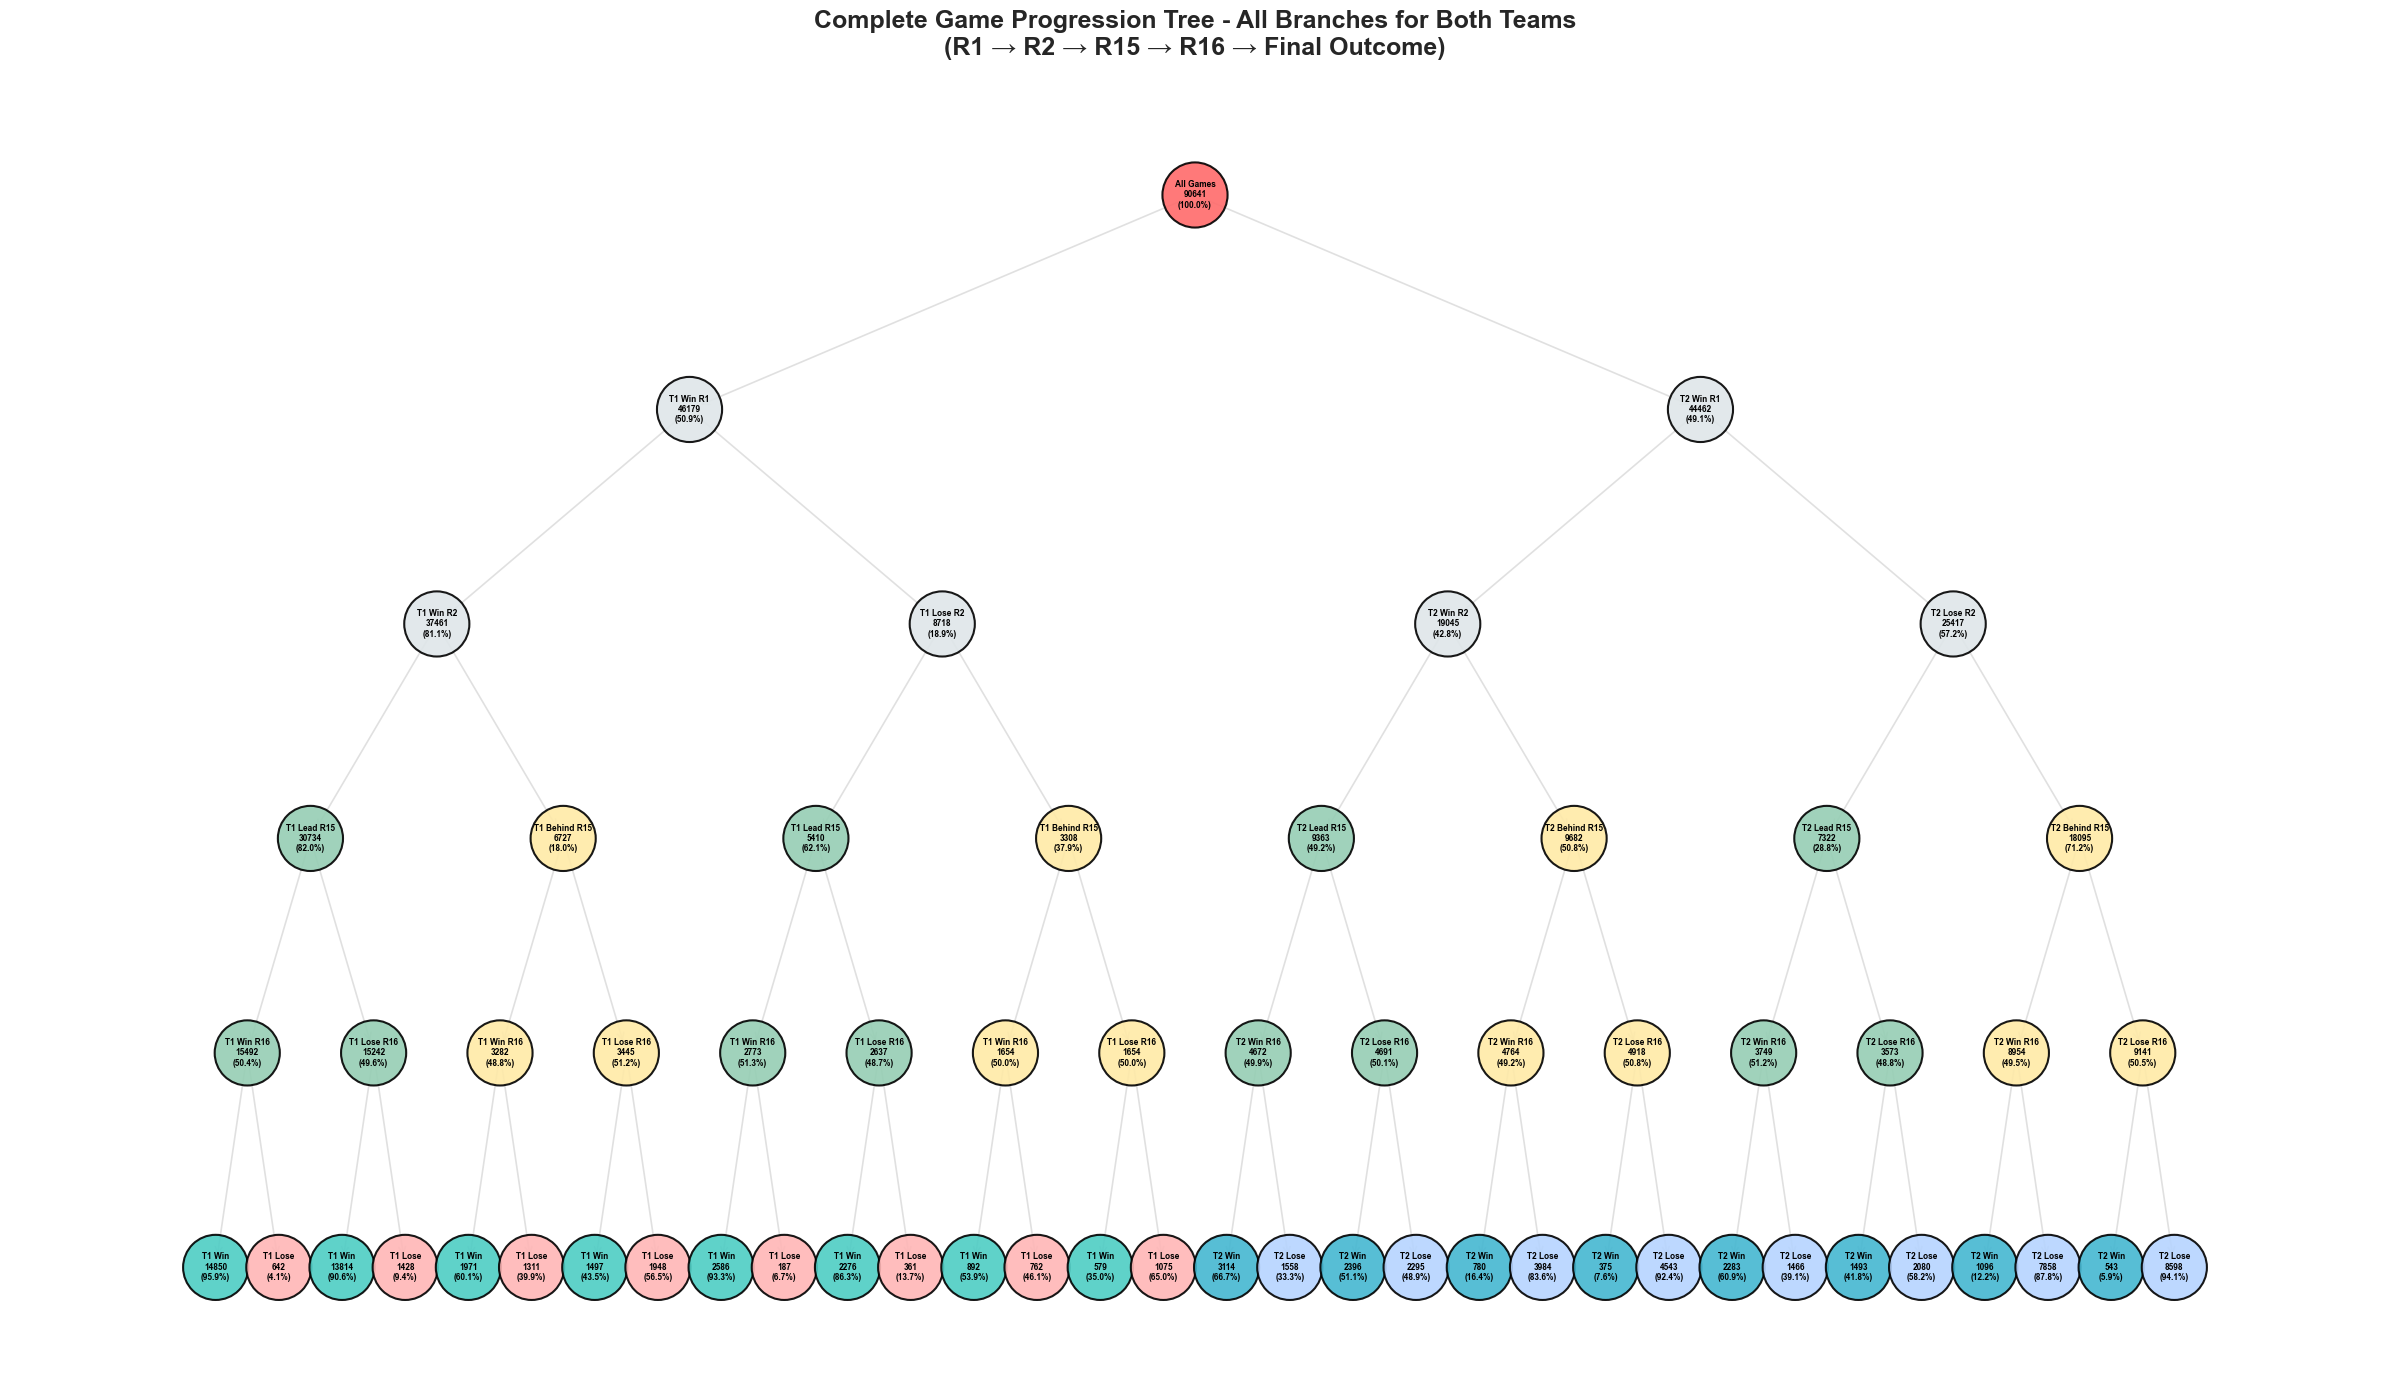


COMPLETE TREE STATISTICS
Total nodes: 63
Total edges: 62
Maximum depth: 5
Total leaf nodes (final outcomes): 32
Total unique paths from start to final outcome: 32

KEY BRANCHING POINTS
After R1: 2 branches
After R2 (T1 path): 2 + 2 branches
After R2 (T2 path): 2 + 2 branches


In [17]:
# Extract game IDs for key rounds - Team 1
t1_r1_win = df_filtered[(df_filtered['is_t1_winner'] == True) & (df_filtered['round_number'] == 1)]['game_id']
t1_r2_win = df_filtered[(df_filtered['is_t1_winner'] == True) & (df_filtered['round_number'] == 2)]['game_id']
t1_r15_win = df_filtered[(df_filtered['t1_score_end'] > df_filtered['t2_score_end']) & (df_filtered['round_number'] == 15)]['game_id']
t1_r16_win = df_filtered[(df_filtered['is_t1_winner'] == True) & (df_filtered['round_number'] == 16)]['game_id']
t1_r17_win = df_filtered[(df_filtered['is_t1_winner'] == True) & (df_filtered['round_number'] == 17)]['game_id']

# Extract game IDs for key rounds - Team 2
t2_r1_win = df_filtered[(df_filtered['is_t1_winner'] == False) & (df_filtered['round_number'] == 1)]['game_id']
t2_r2_win = df_filtered[(df_filtered['is_t1_winner'] == False) & (df_filtered['round_number'] == 2)]['game_id']
t2_r15_win = df_filtered[(df_filtered['t2_score_end'] > df_filtered['t1_score_end']) & (df_filtered['round_number'] == 15)]['game_id']
t2_r16_win = df_filtered[(df_filtered['is_t1_winner'] == False) & (df_filtered['round_number'] == 16)]['game_id']
t2_r17_win = df_filtered[(df_filtered['is_t1_winner'] == False) & (df_filtered['round_number'] == 17)]['game_id']

game_scores = df_filtered.groupby('game_id')[['t1_score_end','t2_score_end']].max()
t1_overall_win = game_scores[game_scores['t1_score_end'] > game_scores['t2_score_end']].index
t2_overall_win = game_scores[game_scores['t2_score_end'] > game_scores['t1_score_end']].index

import networkx as nx
import matplotlib.pyplot as plt

# Calculate metrics from your data
total_games = df_filtered['game_id'].nunique()

# Team 1 R1 wins branch
r1_t1_wins = len(t1_r1_win)
r1_t2_wins = total_games - r1_t1_wins

# T1 wins R1 -> R2
r2_t1_wins_from_t1r1 = len(set(t1_r1_win) & set(t1_r2_win))
r2_t1_losses_from_t1r1 = r1_t1_wins - r2_t1_wins_from_t1r1

# T1 wins R1 -> T1 wins R2 -> R15
r15_t1_lead_from_t1r2win = len(set(t1_r1_win) & set(t1_r2_win) & set(t1_r15_win))
r15_t1_behind_from_t1r2win = r2_t1_wins_from_t1r1 - r15_t1_lead_from_t1r2win

# T1 wins R1 -> T1 loses R2 -> R15
t1r1_t1r2loss_games = set(t1_r1_win) - set(t1_r2_win)
r15_t1_lead_from_t1r2loss = len(t1r1_t1r2loss_games & set(t1_r15_win))
r15_t1_behind_from_t1r2loss = len(t1r1_t1r2loss_games) - r15_t1_lead_from_t1r2loss

# T1 wins R1 -> T1 wins R2 -> T1 leads R15 -> R16
t1r1_t1r2_t1r15lead_games = set(t1_r1_win) & set(t1_r2_win) & set(t1_r15_win)
r16_t1_wins_from_t1r15lead = len(t1r1_t1r2_t1r15lead_games & set(t1_r16_win))
r16_t1_losses_from_t1r15lead = r15_t1_lead_from_t1r2win - r16_t1_wins_from_t1r15lead

# T1 wins R1 -> T1 wins R2 -> T1 behind R15 -> R16
t1r1_t1r2_t1r15behind_games = (set(t1_r1_win) & set(t1_r2_win)) - set(t1_r15_win)
r16_t1_wins_from_t1r15behind = len(t1r1_t1r2_t1r15behind_games & set(t1_r16_win))
r16_t1_losses_from_t1r15behind = r15_t1_behind_from_t1r2win - r16_t1_wins_from_t1r15behind

# T1 wins R1 -> T1 loses R2 -> T1 leads R15 -> R16
t1r1_t1r2loss_t1r15lead_games = t1r1_t1r2loss_games & set(t1_r15_win)
r16_t1_wins_from_t1r2loss_t1r15lead = len(t1r1_t1r2loss_t1r15lead_games & set(t1_r16_win))
r16_t1_losses_from_t1r2loss_t1r15lead = r15_t1_lead_from_t1r2loss - r16_t1_wins_from_t1r2loss_t1r15lead

# T1 wins R1 -> T1 loses R2 -> T1 behind R15 -> R16
t1r1_t1r2loss_t1r15behind_games = t1r1_t1r2loss_games - set(t1_r15_win)
r16_t1_wins_from_t1r2loss_t1r15behind = len(t1r1_t1r2loss_t1r15behind_games & set(t1_r16_win))
r16_t1_losses_from_t1r2loss_t1r15behind = r15_t1_behind_from_t1r2loss - r16_t1_wins_from_t1r2loss_t1r15behind

# Final outcomes from T1 winning R1 path
final_t1_wins_from_r2win_r15lead_r16win = len(t1r1_t1r2_t1r15lead_games & set(t1_r16_win) & set(t1_overall_win))
final_t1_losses_from_r2win_r15lead_r16win = r16_t1_wins_from_t1r15lead - final_t1_wins_from_r2win_r15lead_r16win

final_t1_wins_from_r2win_r15lead_r16loss = len((t1r1_t1r2_t1r15lead_games - set(t1_r16_win)) & set(t1_overall_win))
final_t1_losses_from_r2win_r15lead_r16loss = r16_t1_losses_from_t1r15lead - final_t1_wins_from_r2win_r15lead_r16loss

final_t1_wins_from_r2win_r15behind_r16win = len((t1r1_t1r2_t1r15behind_games & set(t1_r16_win)) & set(t1_overall_win))
final_t1_losses_from_r2win_r15behind_r16win = r16_t1_wins_from_t1r15behind - final_t1_wins_from_r2win_r15behind_r16win

final_t1_wins_from_r2win_r15behind_r16loss = len((t1r1_t1r2_t1r15behind_games - set(t1_r16_win)) & set(t1_overall_win))
final_t1_losses_from_r2win_r15behind_r16loss = r16_t1_losses_from_t1r15behind - final_t1_wins_from_r2win_r15behind_r16loss

final_t1_wins_from_r2loss_r15lead_r16win = len((t1r1_t1r2loss_t1r15lead_games & set(t1_r16_win)) & set(t1_overall_win))
final_t1_losses_from_r2loss_r15lead_r16win = r16_t1_wins_from_t1r2loss_t1r15lead - final_t1_wins_from_r2loss_r15lead_r16win

final_t1_wins_from_r2loss_r15lead_r16loss = len((t1r1_t1r2loss_t1r15lead_games - set(t1_r16_win)) & set(t1_overall_win))
final_t1_losses_from_r2loss_r15lead_r16loss = r16_t1_losses_from_t1r2loss_t1r15lead - final_t1_wins_from_r2loss_r15lead_r16loss

final_t1_wins_from_r2loss_r15behind_r16win = len((t1r1_t1r2loss_t1r15behind_games & set(t1_r16_win)) & set(t1_overall_win))
final_t1_losses_from_r2loss_r15behind_r16win = r16_t1_wins_from_t1r2loss_t1r15behind - final_t1_wins_from_r2loss_r15behind_r16win

final_t1_wins_from_r2loss_r15behind_r16loss = len((t1r1_t1r2loss_t1r15behind_games - set(t1_r16_win)) & set(t1_overall_win))
final_t1_losses_from_r2loss_r15behind_r16loss = r16_t1_losses_from_t1r2loss_t1r15behind - final_t1_wins_from_r2loss_r15behind_r16loss

# Team 2 R1 wins branch
# T2 wins R1 -> R2
r2_t2_wins_from_t2r1 = len(set(t2_r1_win) & set(t2_r2_win))
r2_t2_losses_from_t2r1 = r1_t2_wins - r2_t2_wins_from_t2r1

# T2 wins R1 -> T2 wins R2 -> R15
r15_t2_lead_from_t2r2win = len(set(t2_r1_win) & set(t2_r2_win) & set(t2_r15_win))
r15_t2_behind_from_t2r2win = r2_t2_wins_from_t2r1 - r15_t2_lead_from_t2r2win

# T2 wins R1 -> T2 loses R2 -> R15
t2r1_t2r2loss_games = set(t2_r1_win) - set(t2_r2_win)
r15_t2_lead_from_t2r2loss = len(t2r1_t2r2loss_games & set(t2_r15_win))
r15_t2_behind_from_t2r2loss = len(t2r1_t2r2loss_games) - r15_t2_lead_from_t2r2loss

# T2 wins R1 -> T2 wins R2 -> T2 leads R15 -> R16
t2r1_t2r2_t2r15lead_games = set(t2_r1_win) & set(t2_r2_win) & set(t2_r15_win)
r16_t2_wins_from_t2r15lead = len(t2r1_t2r2_t2r15lead_games & set(t2_r16_win))
r16_t2_losses_from_t2r15lead = r15_t2_lead_from_t2r2win - r16_t2_wins_from_t2r15lead

# T2 wins R1 -> T2 wins R2 -> T2 behind R15 -> R16
t2r1_t2r2_t2r15behind_games = (set(t2_r1_win) & set(t2_r2_win)) - set(t2_r15_win)
r16_t2_wins_from_t2r15behind = len(t2r1_t2r2_t2r15behind_games & set(t2_r16_win))
r16_t2_losses_from_t2r15behind = r15_t2_behind_from_t2r2win - r16_t2_wins_from_t2r15behind

# T2 wins R1 -> T2 loses R2 -> T2 leads R15 -> R16
t2r1_t2r2loss_t2r15lead_games = t2r1_t2r2loss_games & set(t2_r15_win)
r16_t2_wins_from_t2r2loss_t2r15lead = len(t2r1_t2r2loss_t2r15lead_games & set(t2_r16_win))
r16_t2_losses_from_t2r2loss_t2r15lead = r15_t2_lead_from_t2r2loss - r16_t2_wins_from_t2r2loss_t2r15lead

# T2 wins R1 -> T2 loses R2 -> T2 behind R15 -> R16
t2r1_t2r2loss_t2r15behind_games = t2r1_t2r2loss_games - set(t2_r15_win)
r16_t2_wins_from_t2r2loss_t2r15behind = len(t2r1_t2r2loss_t2r15behind_games & set(t2_r16_win))
r16_t2_losses_from_t2r2loss_t2r15behind = r15_t2_behind_from_t2r2loss - r16_t2_wins_from_t2r2loss_t2r15behind

# Final outcomes from T2 winning R1 path
final_t2_wins_from_r2win_r15lead_r16win = len(t2r1_t2r2_t2r15lead_games & set(t2_r16_win) & set(t2_overall_win))
final_t2_losses_from_r2win_r15lead_r16win = r16_t2_wins_from_t2r15lead - final_t2_wins_from_r2win_r15lead_r16win

final_t2_wins_from_r2win_r15lead_r16loss = len((t2r1_t2r2_t2r15lead_games - set(t2_r16_win)) & set(t2_overall_win))
final_t2_losses_from_r2win_r15lead_r16loss = r16_t2_losses_from_t2r15lead - final_t2_wins_from_r2win_r15lead_r16loss

final_t2_wins_from_r2win_r15behind_r16win = len((t2r1_t2r2_t2r15behind_games & set(t2_r16_win)) & set(t2_overall_win))
final_t2_losses_from_r2win_r15behind_r16win = r16_t2_wins_from_t2r15behind - final_t2_wins_from_r2win_r15behind_r16win

final_t2_wins_from_r2win_r15behind_r16loss = len((t2r1_t2r2_t2r15behind_games - set(t2_r16_win)) & set(t2_overall_win))
final_t2_losses_from_r2win_r15behind_r16loss = r16_t2_losses_from_t2r15behind - final_t2_wins_from_r2win_r15behind_r16loss

final_t2_wins_from_r2loss_r15lead_r16win = len((t2r1_t2r2loss_t2r15lead_games & set(t2_r16_win)) & set(t2_overall_win))
final_t2_losses_from_r2loss_r15lead_r16win = r16_t2_wins_from_t2r2loss_t2r15lead - final_t2_wins_from_r2loss_r15lead_r16win

final_t2_wins_from_r2loss_r15lead_r16loss = len((t2r1_t2r2loss_t2r15lead_games - set(t2_r16_win)) & set(t2_overall_win))
final_t2_losses_from_r2loss_r15lead_r16loss = r16_t2_losses_from_t2r2loss_t2r15lead - final_t2_wins_from_r2loss_r15lead_r16loss

final_t2_wins_from_r2loss_r15behind_r16win = len((t2r1_t2r2loss_t2r15behind_games & set(t2_r16_win)) & set(t2_overall_win))
final_t2_losses_from_r2loss_r15behind_r16win = r16_t2_wins_from_t2r2loss_t2r15behind - final_t2_wins_from_r2loss_r15behind_r16win

final_t2_wins_from_r2loss_r15behind_r16loss = len((t2r1_t2r2loss_t2r15behind_games - set(t2_r16_win)) & set(t2_overall_win))
final_t2_losses_from_r2loss_r15behind_r16loss = r16_t2_losses_from_t2r2loss_t2r15behind - final_t2_wins_from_r2loss_r15behind_r16loss

# Complete DataFrame with all branches
tree_df = pd.DataFrame([
    # Root
    {'node_id': 'start', 'parent_id': None, 'count': total_games, 'label': 'All Games'},
    
    # First split: R1
    {'node_id': 't1_r1_win', 'parent_id': 'start', 'count': r1_t1_wins, 'label': 'T1 Win R1'},
    {'node_id': 't2_r1_win', 'parent_id': 'start', 'count': r1_t2_wins, 'label': 'T2 Win R1'},
    
    # ===== TEAM 1 PATH: T1 wins R1 =====
    # R2 from T1 R1 win
    {'node_id': 't1_r1w_r2w', 'parent_id': 't1_r1_win', 'count': r2_t1_wins_from_t1r1, 'label': 'T1 Win R2'},
    {'node_id': 't1_r1w_r2l', 'parent_id': 't1_r1_win', 'count': r2_t1_losses_from_t1r1, 'label': 'T1 Lose R2'},
    
    # R15 from T1 R1 win -> T1 R2 win
    {'node_id': 't1_r1w_r2w_r15lead', 'parent_id': 't1_r1w_r2w', 'count': r15_t1_lead_from_t1r2win, 'label': 'T1 Lead R15'},
    {'node_id': 't1_r1w_r2w_r15behind', 'parent_id': 't1_r1w_r2w', 'count': r15_t1_behind_from_t1r2win, 'label': 'T1 Behind R15'},
    
    # R15 from T1 R1 win -> T1 R2 loss
    {'node_id': 't1_r1w_r2l_r15lead', 'parent_id': 't1_r1w_r2l', 'count': r15_t1_lead_from_t1r2loss, 'label': 'T1 Lead R15'},
    {'node_id': 't1_r1w_r2l_r15behind', 'parent_id': 't1_r1w_r2l', 'count': r15_t1_behind_from_t1r2loss, 'label': 'T1 Behind R15'},
    
    # R16 from T1 R1 win -> T1 R2 win -> T1 R15 lead
    {'node_id': 't1_r1w_r2w_r15lead_r16w', 'parent_id': 't1_r1w_r2w_r15lead', 'count': r16_t1_wins_from_t1r15lead, 'label': 'T1 Win R16'},
    {'node_id': 't1_r1w_r2w_r15lead_r16l', 'parent_id': 't1_r1w_r2w_r15lead', 'count': r16_t1_losses_from_t1r15lead, 'label': 'T1 Lose R16'},
    
    # R16 from T1 R1 win -> T1 R2 win -> T1 R15 behind
    {'node_id': 't1_r1w_r2w_r15behind_r16w', 'parent_id': 't1_r1w_r2w_r15behind', 'count': r16_t1_wins_from_t1r15behind, 'label': 'T1 Win R16'},
    {'node_id': 't1_r1w_r2w_r15behind_r16l', 'parent_id': 't1_r1w_r2w_r15behind', 'count': r16_t1_losses_from_t1r15behind, 'label': 'T1 Lose R16'},
    
    # R16 from T1 R1 win -> T1 R2 loss -> T1 R15 lead
    {'node_id': 't1_r1w_r2l_r15lead_r16w', 'parent_id': 't1_r1w_r2l_r15lead', 'count': r16_t1_wins_from_t1r2loss_t1r15lead, 'label': 'T1 Win R16'},
    {'node_id': 't1_r1w_r2l_r15lead_r16l', 'parent_id': 't1_r1w_r2l_r15lead', 'count': r16_t1_losses_from_t1r2loss_t1r15lead, 'label': 'T1 Lose R16'},
    
    # R16 from T1 R1 win -> T1 R2 loss -> T1 R15 behind
    {'node_id': 't1_r1w_r2l_r15behind_r16w', 'parent_id': 't1_r1w_r2l_r15behind', 'count': r16_t1_wins_from_t1r2loss_t1r15behind, 'label': 'T1 Win R16'},
    {'node_id': 't1_r1w_r2l_r15behind_r16l', 'parent_id': 't1_r1w_r2l_r15behind', 'count': r16_t1_losses_from_t1r2loss_t1r15behind, 'label': 'T1 Lose R16'},
    
    # Final outcomes - T1 path
    {'node_id': 't1_r1w_r2w_r15lead_r16w_final_w', 'parent_id': 't1_r1w_r2w_r15lead_r16w', 'count': final_t1_wins_from_r2win_r15lead_r16win, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2w_r15lead_r16w_final_l', 'parent_id': 't1_r1w_r2w_r15lead_r16w', 'count': final_t1_losses_from_r2win_r15lead_r16win, 'label': 'T1 Lose'},
    
    {'node_id': 't1_r1w_r2w_r15lead_r16l_final_w', 'parent_id': 't1_r1w_r2w_r15lead_r16l', 'count': final_t1_wins_from_r2win_r15lead_r16loss, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2w_r15lead_r16l_final_l', 'parent_id': 't1_r1w_r2w_r15lead_r16l', 'count': final_t1_losses_from_r2win_r15lead_r16loss, 'label': 'T1 Lose'},
    
    {'node_id': 't1_r1w_r2w_r15behind_r16w_final_w', 'parent_id': 't1_r1w_r2w_r15behind_r16w', 'count': final_t1_wins_from_r2win_r15behind_r16win, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2w_r15behind_r16w_final_l', 'parent_id': 't1_r1w_r2w_r15behind_r16w', 'count': final_t1_losses_from_r2win_r15behind_r16win, 'label': 'T1 Lose'},
    
    {'node_id': 't1_r1w_r2w_r15behind_r16l_final_w', 'parent_id': 't1_r1w_r2w_r15behind_r16l', 'count': final_t1_wins_from_r2win_r15behind_r16loss, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2w_r15behind_r16l_final_l', 'parent_id': 't1_r1w_r2w_r15behind_r16l', 'count': final_t1_losses_from_r2win_r15behind_r16loss, 'label': 'T1 Lose'},
    
    # Final outcomes - T1 R2 loss path
    {'node_id': 't1_r1w_r2l_r15lead_r16w_final_w', 'parent_id': 't1_r1w_r2l_r15lead_r16w', 'count': final_t1_wins_from_r2loss_r15lead_r16win, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2l_r15lead_r16w_final_l', 'parent_id': 't1_r1w_r2l_r15lead_r16w', 'count': final_t1_losses_from_r2loss_r15lead_r16win, 'label': 'T1 Lose'},
    
    {'node_id': 't1_r1w_r2l_r15lead_r16l_final_w', 'parent_id': 't1_r1w_r2l_r15lead_r16l', 'count': final_t1_wins_from_r2loss_r15lead_r16loss, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2l_r15lead_r16l_final_l', 'parent_id': 't1_r1w_r2l_r15lead_r16l', 'count': final_t1_losses_from_r2loss_r15lead_r16loss, 'label': 'T1 Lose'},
    
    {'node_id': 't1_r1w_r2l_r15behind_r16w_final_w', 'parent_id': 't1_r1w_r2l_r15behind_r16w', 'count': final_t1_wins_from_r2loss_r15behind_r16win, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2l_r15behind_r16w_final_l', 'parent_id': 't1_r1w_r2l_r15behind_r16w', 'count': final_t1_losses_from_r2loss_r15behind_r16win, 'label': 'T1 Lose'},
    
    {'node_id': 't1_r1w_r2l_r15behind_r16l_final_w', 'parent_id': 't1_r1w_r2l_r15behind_r16l', 'count': final_t1_wins_from_r2loss_r15behind_r16loss, 'label': 'T1 Win'},
    {'node_id': 't1_r1w_r2l_r15behind_r16l_final_l', 'parent_id': 't1_r1w_r2l_r15behind_r16l', 'count': final_t1_losses_from_r2loss_r15behind_r16loss, 'label': 'T1 Lose'},
    
    # ===== TEAM 2 PATH: T2 wins R1 =====
    # R2 from T2 R1 win
    {'node_id': 't2_r1w_r2w', 'parent_id': 't2_r1_win', 'count': r2_t2_wins_from_t2r1, 'label': 'T2 Win R2'},
    {'node_id': 't2_r1w_r2l', 'parent_id': 't2_r1_win', 'count': r2_t2_losses_from_t2r1, 'label': 'T2 Lose R2'},
    
    # R15 from T2 R1 win -> T2 R2 win
    {'node_id': 't2_r1w_r2w_r15lead', 'parent_id': 't2_r1w_r2w', 'count': r15_t2_lead_from_t2r2win, 'label': 'T2 Lead R15'},
    {'node_id': 't2_r1w_r2w_r15behind', 'parent_id': 't2_r1w_r2w', 'count': r15_t2_behind_from_t2r2win, 'label': 'T2 Behind R15'},
    
    # R15 from T2 R1 win -> T2 R2 loss
    {'node_id': 't2_r1w_r2l_r15lead', 'parent_id': 't2_r1w_r2l', 'count': r15_t2_lead_from_t2r2loss, 'label': 'T2 Lead R15'},
    {'node_id': 't2_r1w_r2l_r15behind', 'parent_id': 't2_r1w_r2l', 'count': r15_t2_behind_from_t2r2loss, 'label': 'T2 Behind R15'},
    
    # R16 from T2 R1 win -> T2 R2 win -> T2 R15 lead
    {'node_id': 't2_r1w_r2w_r15lead_r16w', 'parent_id': 't2_r1w_r2w_r15lead', 'count': r16_t2_wins_from_t2r15lead, 'label': 'T2 Win R16'},
    {'node_id': 't2_r1w_r2w_r15lead_r16l', 'parent_id': 't2_r1w_r2w_r15lead', 'count': r16_t2_losses_from_t2r15lead, 'label': 'T2 Lose R16'},
    
    # R16 from T2 R1 win -> T2 R2 win -> T2 R15 behind
    {'node_id': 't2_r1w_r2w_r15behind_r16w', 'parent_id': 't2_r1w_r2w_r15behind', 'count': r16_t2_wins_from_t2r15behind, 'label': 'T2 Win R16'},
    {'node_id': 't2_r1w_r2w_r15behind_r16l', 'parent_id': 't2_r1w_r2w_r15behind', 'count': r16_t2_losses_from_t2r15behind, 'label': 'T2 Lose R16'},
    
    # R16 from T2 R1 win -> T2 R2 loss -> T2 R15 lead
    {'node_id': 't2_r1w_r2l_r15lead_r16w', 'parent_id': 't2_r1w_r2l_r15lead', 'count': r16_t2_wins_from_t2r2loss_t2r15lead, 'label': 'T2 Win R16'},
    {'node_id': 't2_r1w_r2l_r15lead_r16l', 'parent_id': 't2_r1w_r2l_r15lead', 'count': r16_t2_losses_from_t2r2loss_t2r15lead, 'label': 'T2 Lose R16'},
    
    # R16 from T2 R1 win -> T2 R2 loss -> T2 R15 behind
    {'node_id': 't2_r1w_r2l_r15behind_r16w', 'parent_id': 't2_r1w_r2l_r15behind', 'count': r16_t2_wins_from_t2r2loss_t2r15behind, 'label': 'T2 Win R16'},
    {'node_id': 't2_r1w_r2l_r15behind_r16l', 'parent_id': 't2_r1w_r2l_r15behind', 'count': r16_t2_losses_from_t2r2loss_t2r15behind, 'label': 'T2 Lose R16'},
    
    # Final outcomes - T2 path
    {'node_id': 't2_r1w_r2w_r15lead_r16w_final_w', 'parent_id': 't2_r1w_r2w_r15lead_r16w', 'count': final_t2_wins_from_r2win_r15lead_r16win, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2w_r15lead_r16w_final_l', 'parent_id': 't2_r1w_r2w_r15lead_r16w', 'count': final_t2_losses_from_r2win_r15lead_r16win, 'label': 'T2 Lose'},
    
    {'node_id': 't2_r1w_r2w_r15lead_r16l_final_w', 'parent_id': 't2_r1w_r2w_r15lead_r16l', 'count': final_t2_wins_from_r2win_r15lead_r16loss, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2w_r15lead_r16l_final_l', 'parent_id': 't2_r1w_r2w_r15lead_r16l', 'count': final_t2_losses_from_r2win_r15lead_r16loss, 'label': 'T2 Lose'},
    
    {'node_id': 't2_r1w_r2w_r15behind_r16w_final_w', 'parent_id': 't2_r1w_r2w_r15behind_r16w', 'count': final_t2_wins_from_r2win_r15behind_r16win, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2w_r15behind_r16w_final_l', 'parent_id': 't2_r1w_r2w_r15behind_r16w', 'count': final_t2_losses_from_r2win_r15behind_r16win, 'label': 'T2 Lose'},
    
    {'node_id': 't2_r1w_r2w_r15behind_r16l_final_w', 'parent_id': 't2_r1w_r2w_r15behind_r16l', 'count': final_t2_wins_from_r2win_r15behind_r16loss, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2w_r15behind_r16l_final_l', 'parent_id': 't2_r1w_r2w_r15behind_r16l', 'count': final_t2_losses_from_r2win_r15behind_r16loss, 'label': 'T2 Lose'},
    
    # Final outcomes - T2 R2 loss path
    {'node_id': 't2_r1w_r2l_r15lead_r16w_final_w', 'parent_id': 't2_r1w_r2l_r15lead_r16w', 'count': final_t2_wins_from_r2loss_r15lead_r16win, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2l_r15lead_r16w_final_l', 'parent_id': 't2_r1w_r2l_r15lead_r16w', 'count': final_t2_losses_from_r2loss_r15lead_r16win, 'label': 'T2 Lose'},
    
    {'node_id': 't2_r1w_r2l_r15lead_r16l_final_w', 'parent_id': 't2_r1w_r2l_r15lead_r16l', 'count': final_t2_wins_from_r2loss_r15lead_r16loss, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2l_r15lead_r16l_final_l', 'parent_id': 't2_r1w_r2l_r15lead_r16l', 'count': final_t2_losses_from_r2loss_r15lead_r16loss, 'label': 'T2 Lose'},
    
    {'node_id': 't2_r1w_r2l_r15behind_r16w_final_w', 'parent_id': 't2_r1w_r2l_r15behind_r16w', 'count': final_t2_wins_from_r2loss_r15behind_r16win, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2l_r15behind_r16w_final_l', 'parent_id': 't2_r1w_r2l_r15behind_r16w', 'count': final_t2_losses_from_r2loss_r15behind_r16win, 'label': 'T2 Lose'},
    
    {'node_id': 't2_r1w_r2l_r15behind_r16l_final_w', 'parent_id': 't2_r1w_r2l_r15behind_r16l', 'count': final_t2_wins_from_r2loss_r15behind_r16loss, 'label': 'T2 Win'},
    {'node_id': 't2_r1w_r2l_r15behind_r16l_final_l', 'parent_id': 't2_r1w_r2l_r15behind_r16l', 'count': final_t2_losses_from_r2loss_r15behind_r16loss, 'label': 'T2 Lose'},
])

def build_tree_from_dataframe(df):
    """Build tree from DataFrame with automatic percentage calculation"""
    G = nx.DiGraph()
    
    # First pass: add all nodes
    for idx, row in df.iterrows():
        G.add_node(row['node_id'], count=row['count'], label=row['label'])
    
    # Second pass: calculate percentages and add edges
    for idx, row in df.iterrows():
        if pd.notna(row['parent_id']) and row['parent_id'] is not None:
            parent_count = G.nodes[row['parent_id']]['count']
            percentage = (row['count'] / parent_count * 100) if parent_count > 0 else 0
            G.nodes[row['node_id']]['percentage'] = percentage
            G.add_edge(row['parent_id'], row['node_id'])
        else:
            G.nodes[row['node_id']]['percentage'] = 100.0
    
    return G

# Build the tree
G = build_tree_from_dataframe(tree_df)

# Create formatted labels with count and percentage
labels = {}
for node in G.nodes():
    data = G.nodes[node]
    labels[node] = f"{data['label']}\n{data['count']}\n({data['percentage']:.1f}%)"

# Visualize with hierarchical layout
plt.figure(figsize=(24, 14))

# Define hierarchical positions
def hierarchy_pos(G, root, width=1., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """Create hierarchical tree layout"""
    def _hierarchy_pos(G, root, leftmost, width, leafdx=0.2, vert_gap=0.5, 
                       vert_loc=0, xcenter=0.5, rootpos=None, leafpos=None, parent=None):
        if rootpos is None:
            rootpos = {root: (xcenter, vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        
        children = list(G.neighbors(root))
        if not children:
            return rootpos, leafdx
        
        dx = width / len(children)
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            rootpos, leafdx = _hierarchy_pos(G, child, leftmost+dx, width=dx,
                                            leafdx=leafdx, vert_gap=vert_gap,
                                            vert_loc=vert_loc-vert_gap, xcenter=nextx,
                                            rootpos=rootpos, leafpos=leafpos, parent=root)
        return rootpos, leafdx
    
    return _hierarchy_pos(G, root, 0, width)[0]

pos = hierarchy_pos(G, 'start', width=4.5, vert_gap=1.0)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='#CCCCCC', arrows=True, 
                       arrowsize=12, width=1.2, arrowstyle='->', alpha=0.6)

# Draw nodes with color based on team and outcome
node_colors = []
for node in G.nodes():
    node_id = node
    if node == 'start':
        node_colors.append('#FF6B6B')  # Root - red
    elif 't1' in node_id and ('final_w' in node_id or node_id.endswith('_w')):
        node_colors.append('#4ECDC4')  # T1 wins - cyan
    elif 't1' in node_id and ('final_l' in node_id or node_id.endswith('_l')):
        node_colors.append('#FFB6B6')  # T1 losses - light red
    elif 't2' in node_id and ('final_w' in node_id or node_id.endswith('_w')):
        node_colors.append('#45B7D1')  # T2 wins - blue
    elif 't2' in node_id and ('final_l' in node_id or node_id.endswith('_l')):
        node_colors.append('#B6D4FF')  # T2 losses - light blue
    elif 'lead' in node_id:
        node_colors.append('#96CEB4')  # Lead - green
    elif 'behind' in node_id:
        node_colors.append('#FFEAA7')  # Behind - yellow
    else:
        node_colors.append('#DFE6E9')  # Default - gray

nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                       node_size=2200, edgecolors='black', linewidths=1.5, alpha=0.9)

# Draw labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_weight='bold')

plt.title('Complete Game Progression Tree - All Branches for Both Teams\n(R1 → R2 → R15 → R16 → Final Outcome)', 
          fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Statistics summary
print(f"\n{'='*80}")
print("COMPLETE TREE STATISTICS")
print(f"{'='*80}")
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Maximum depth: {max(nx.shortest_path_length(G, 'start').values())}")
print(f"Total leaf nodes (final outcomes): {sum(1 for node in G.nodes() if G.out_degree(node) == 0)}")

# Count paths
all_paths = list(nx.all_simple_paths(G, 'start', [n for n in G.nodes() if G.out_degree(n) == 0]))
print(f"Total unique paths from start to final outcome: {len(all_paths)}")

print(f"\n{'='*80}")
print("KEY BRANCHING POINTS")
print(f"{'='*80}")
print(f"After R1: {len(list(G.neighbors('start')))} branches")
print(f"After R2 (T1 path): {len(list(G.neighbors('t1_r1w_r2w')))} + {len(list(G.neighbors('t1_r1w_r2l')))} branches")
print(f"After R2 (T2 path): {len(list(G.neighbors('t2_r1w_r2w')))} + {len(list(G.neighbors('t2_r1w_r2l')))} branches")
print(f"{'='*80}")

## Way to win - Improved Calculation & Visualization

Refactored calculation with helper functions for better readability, plus Sankey and Graphviz visualizations.

In [18]:
# ============================================================================
# IMPROVED CALCULATION - Cleaner, more modular code
# ============================================================================

def extract_game_ids(df, team_col, round_num, condition=None):
    """Extract game IDs for specific round outcomes"""
    if condition is None:
        mask = (df[team_col] == True) & (df['round_number'] == round_num)
    else:
        mask = condition & (df['round_number'] == round_num)
    return set(df[mask]['game_id'])

def calculate_branch_counts(parent_games, *filters):
    """Calculate counts for multiple branches from a parent set"""
    results = []
    for filter_games in filters:
        count = len(parent_games & filter_games)
        results.append(count)
    return results

# Extract base round outcomes
print("Extracting game outcomes...")
total_games = df_filtered['game_id'].nunique()

# R1 outcomes
t1_r1_win = extract_game_ids(df_filtered, 'is_t1_winner', 1)
t2_r1_win = extract_game_ids(df_filtered, 'is_t1_winner', 1) 
t2_r1_win = set(df_filtered[df_filtered['round_number'] == 1]['game_id']) - t1_r1_win

# R2 outcomes
t1_r2_win = extract_game_ids(df_filtered, 'is_t1_winner', 2)
t2_r2_win = set(df_filtered[df_filtered['round_number'] == 2]['game_id']) - t1_r2_win

# R15 lead/behind (at end of first half)
t1_r15_lead = extract_game_ids(df_filtered, None, 15, 
                               df_filtered['t1_score_end'] > df_filtered['t2_score_end'])
t2_r15_lead = extract_game_ids(df_filtered, None, 15,
                               df_filtered['t2_score_end'] > df_filtered['t1_score_end'])

# R16 outcomes
t1_r16_win = extract_game_ids(df_filtered, 'is_t1_winner', 16)
t2_r16_win = set(df_filtered[df_filtered['round_number'] == 16]['game_id']) - t1_r16_win

# Final game outcomes
game_scores = df_filtered.groupby('game_id')[['t1_score_end','t2_score_end']].max()
t1_overall_win = set(game_scores[game_scores['t1_score_end'] > game_scores['t2_score_end']].index)
t2_overall_win = set(game_scores[game_scores['t2_score_end'] > game_scores['t1_score_end']].index)

# ============================================================================
# Calculate all branch counts using helper functions
# ============================================================================

print("Calculating branch counts...")

# Level 1: R1 split
r1_counts = {
    't1_wins': len(t1_r1_win),
    't2_wins': len(t2_r1_win)
}

# Level 2: R2 outcomes for each R1 branch
t1_r2_branches = calculate_branch_counts(t1_r1_win, t1_r2_win, t2_r2_win)
t2_r2_branches = calculate_branch_counts(t2_r1_win, t2_r2_win, t1_r2_win)

# Level 3: R15 outcomes for each R2 branch
# T1 R1 win -> T1 R2 win
t1r1w_t1r2w = t1_r1_win & t1_r2_win
t1r1w_t1r2w_r15 = calculate_branch_counts(t1r1w_t1r2w, t1_r15_lead, t2_r15_lead)

# T1 R1 win -> T1 R2 loss
t1r1w_t1r2l = t1_r1_win & t2_r2_win
t1r1w_t1r2l_r15 = calculate_branch_counts(t1r1w_t1r2l, t1_r15_lead, t2_r15_lead)

# T2 R1 win -> T2 R2 win
t2r1w_t2r2w = t2_r1_win & t2_r2_win
t2r1w_t2r2w_r15 = calculate_branch_counts(t2r1w_t2r2w, t2_r15_lead, t1_r15_lead)

# T2 R1 win -> T2 R2 loss
t2r1w_t2r2l = t2_r1_win & t1_r2_win
t2r1w_t2r2l_r15 = calculate_branch_counts(t2r1w_t2r2l, t2_r15_lead, t1_r15_lead)

# Level 4: R16 outcomes for each R15 branch
# T1 paths
t1r1w_t1r2w_t1r15lead = t1r1w_t1r2w & t1_r15_lead
t1r1w_t1r2w_t1r15lead_r16 = calculate_branch_counts(t1r1w_t1r2w_t1r15lead, t1_r16_win, t2_r16_win)

t1r1w_t1r2w_t1r15behind = t1r1w_t1r2w & t2_r15_lead
t1r1w_t1r2w_t1r15behind_r16 = calculate_branch_counts(t1r1w_t1r2w_t1r15behind, t1_r16_win, t2_r16_win)

t1r1w_t1r2l_t1r15lead = t1r1w_t1r2l & t1_r15_lead
t1r1w_t1r2l_t1r15lead_r16 = calculate_branch_counts(t1r1w_t1r2l_t1r15lead, t1_r16_win, t2_r16_win)

t1r1w_t1r2l_t1r15behind = t1r1w_t1r2l & t2_r15_lead
t1r1w_t1r2l_t1r15behind_r16 = calculate_branch_counts(t1r1w_t1r2l_t1r15behind, t1_r16_win, t2_r16_win)

# T2 paths
t2r1w_t2r2w_t2r15lead = t2r1w_t2r2w & t2_r15_lead
t2r1w_t2r2w_t2r15lead_r16 = calculate_branch_counts(t2r1w_t2r2w_t2r15lead, t2_r16_win, t1_r16_win)

t2r1w_t2r2w_t2r15behind = t2r1w_t2r2w & t1_r15_lead
t2r1w_t2r2w_t2r15behind_r16 = calculate_branch_counts(t2r1w_t2r2w_t2r15behind, t2_r16_win, t1_r16_win)

t2r1w_t2r2l_t2r15lead = t2r1w_t2r2l & t2_r15_lead
t2r1w_t2r2l_t2r15lead_r16 = calculate_branch_counts(t2r1w_t2r2l_t2r15lead, t2_r16_win, t1_r16_win)

t2r1w_t2r2l_t2r15behind = t2r1w_t2r2l & t1_r15_lead
t2r1w_t2r2l_t2r15behind_r16 = calculate_branch_counts(t2r1w_t2r2l_t2r15behind, t2_r16_win, t1_r16_win)

# Level 5: Final outcomes for each R16 branch
# T1 R2 win paths
t1_final_counts = {
    'r2w_r15lead_r16w': calculate_branch_counts(t1r1w_t1r2w_t1r15lead & t1_r16_win, t1_overall_win, t2_overall_win),
    'r2w_r15lead_r16l': calculate_branch_counts(t1r1w_t1r2w_t1r15lead & t2_r16_win, t1_overall_win, t2_overall_win),
    'r2w_r15behind_r16w': calculate_branch_counts(t1r1w_t1r2w_t1r15behind & t1_r16_win, t1_overall_win, t2_overall_win),
    'r2w_r15behind_r16l': calculate_branch_counts(t1r1w_t1r2w_t1r15behind & t2_r16_win, t1_overall_win, t2_overall_win),
    'r2l_r15lead_r16w': calculate_branch_counts(t1r1w_t1r2l_t1r15lead & t1_r16_win, t1_overall_win, t2_overall_win),
    'r2l_r15lead_r16l': calculate_branch_counts(t1r1w_t1r2l_t1r15lead & t2_r16_win, t1_overall_win, t2_overall_win),
    'r2l_r15behind_r16w': calculate_branch_counts(t1r1w_t1r2l_t1r15behind & t1_r16_win, t1_overall_win, t2_overall_win),
    'r2l_r15behind_r16l': calculate_branch_counts(t1r1w_t1r2l_t1r15behind & t2_r16_win, t1_overall_win, t2_overall_win),
}

# T2 final paths
t2_final_counts = {
    'r2w_r15lead_r16w': calculate_branch_counts(t2r1w_t2r2w_t2r15lead & t2_r16_win, t2_overall_win, t1_overall_win),
    'r2w_r15lead_r16l': calculate_branch_counts(t2r1w_t2r2w_t2r15lead & t1_r16_win, t2_overall_win, t1_overall_win),
    'r2w_r15behind_r16w': calculate_branch_counts(t2r1w_t2r2w_t2r15behind & t2_r16_win, t2_overall_win, t1_overall_win),
    'r2w_r15behind_r16l': calculate_branch_counts(t2r1w_t2r2w_t2r15behind & t1_r16_win, t2_overall_win, t1_overall_win),
    'r2l_r15lead_r16w': calculate_branch_counts(t2r1w_t2r2l_t2r15lead & t2_r16_win, t2_overall_win, t1_overall_win),
    'r2l_r15lead_r16l': calculate_branch_counts(t2r1w_t2r2l_t2r15lead & t1_r16_win, t2_overall_win, t1_overall_win),
    'r2l_r15behind_r16w': calculate_branch_counts(t2r1w_t2r2l_t2r15behind & t2_r16_win, t2_overall_win, t1_overall_win),
    'r2l_r15behind_r16l': calculate_branch_counts(t2r1w_t2r2l_t2r15behind & t1_r16_win, t2_overall_win, t1_overall_win),
}

print(f"✓ Calculation complete! Total games: {total_games}")
print(f"  T1 R1 wins: {r1_counts['t1_wins']} ({r1_counts['t1_wins']/total_games*100:.1f}%)")
print(f"  T2 R1 wins: {r1_counts['t2_wins']} ({r1_counts['t2_wins']/total_games*100:.1f}%)")

Extracting game outcomes...
Calculating branch counts...
✓ Calculation complete! Total games: 90641
  T1 R1 wins: 46179 (50.9%)
  T2 R1 wins: 44462 (49.1%)


In [19]:
# ============================================================================
# SANKEY DIAGRAM - Interactive flow visualization
# ============================================================================

import plotly.graph_objects as go

def create_sankey_data():
    """Build Sankey diagram source/target/value arrays"""
    
    # Node labels (indexed)
    labels = [
        "All Games",  # 0
        
        # R1 level
        "T1 Win R1", "T2 Win R1",  # 1, 2
        
        # R2 level - T1 path
        "T1: Win R2", "T1: Lose R2",  # 3, 4
        # R2 level - T2 path
        "T2: Win R2", "T2: Lose R2",  # 5, 6
        
        # R15 level - T1 R2 win
        "T1: R2W→Lead R15", "T1: R2W→Behind R15",  # 7, 8
        # R15 level - T1 R2 loss
        "T1: R2L→Lead R15", "T1: R2L→Behind R15",  # 9, 10
        # R15 level - T2 R2 win
        "T2: R2W→Lead R15", "T2: R2W→Behind R15",  # 11, 12
        # R15 level - T2 R2 loss
        "T2: R2L→Lead R15", "T2: R2L→Behind R15",  # 13, 14
        
        # R16 level - T1 paths (8 nodes)
        "T1: R2W,Lead→Win R16", "T1: R2W,Lead→Lose R16",  # 15, 16
        "T1: R2W,Behind→Win R16", "T1: R2W,Behind→Lose R16",  # 17, 18
        "T1: R2L,Lead→Win R16", "T1: R2L,Lead→Lose R16",  # 19, 20
        "T1: R2L,Behind→Win R16", "T1: R2L,Behind→Lose R16",  # 21, 22
        
        # R16 level - T2 paths (8 nodes)
        "T2: R2W,Lead→Win R16", "T2: R2W,Lead→Lose R16",  # 23, 24
        "T2: R2W,Behind→Win R16", "T2: R2W,Behind→Lose R16",  # 25, 26
        "T2: R2L,Lead→Win R16", "T2: R2L,Lead→Lose R16",  # 27, 28
        "T2: R2L,Behind→Win R16", "T2: R2L,Behind→Lose R16",  # 29, 30
        
        # Final outcomes - T1 paths (16 nodes: 8 wins, 8 losses)
        "T1 WIN (R2W,Lead,R16W)", "T1 LOSE (R2W,Lead,R16W)",  # 31, 32
        "T1 WIN (R2W,Lead,R16L)", "T1 LOSE (R2W,Lead,R16L)",  # 33, 34
        "T1 WIN (R2W,Behind,R16W)", "T1 LOSE (R2W,Behind,R16W)",  # 35, 36
        "T1 WIN (R2W,Behind,R16L)", "T1 LOSE (R2W,Behind,R16L)",  # 37, 38
        "T1 WIN (R2L,Lead,R16W)", "T1 LOSE (R2L,Lead,R16W)",  # 39, 40
        "T1 WIN (R2L,Lead,R16L)", "T1 LOSE (R2L,Lead,R16L)",  # 41, 42
        "T1 WIN (R2L,Behind,R16W)", "T1 LOSE (R2L,Behind,R16W)",  # 43, 44
        "T1 WIN (R2L,Behind,R16L)", "T1 LOSE (R2L,Behind,R16L)",  # 45, 46
        
        # Final outcomes - T2 paths (16 nodes: 8 wins, 8 losses)
        "T2 WIN (R2W,Lead,R16W)", "T2 LOSE (R2W,Lead,R16W)",  # 47, 48
        "T2 WIN (R2W,Lead,R16L)", "T2 LOSE (R2W,Lead,R16L)",  # 49, 50
        "T2 WIN (R2W,Behind,R16W)", "T2 LOSE (R2W,Behind,R16W)",  # 51, 52
        "T2 WIN (R2W,Behind,R16L)", "T2 LOSE (R2W,Behind,R16L)",  # 53, 54
        "T2 WIN (R2L,Lead,R16W)", "T2 LOSE (R2L,Lead,R16W)",  # 55, 56
        "T2 WIN (R2L,Lead,R16L)", "T2 LOSE (R2L,Lead,R16L)",  # 57, 58
        "T2 WIN (R2L,Behind,R16W)", "T2 LOSE (R2L,Behind,R16W)",  # 59, 60
        "T2 WIN (R2L,Behind,R16L)", "T2 LOSE (R2L,Behind,R16L)",  # 61, 62
    ]
    
    sources = []
    targets = []
    values = []
    
    # Root to R1
    sources.extend([0, 0])
    targets.extend([1, 2])
    values.extend([r1_counts['t1_wins'], r1_counts['t2_wins']])
    
    # R1 to R2
    sources.extend([1, 1, 2, 2])
    targets.extend([3, 4, 5, 6])
    values.extend(t1_r2_branches + t2_r2_branches)
    
    # R2 to R15
    sources.extend([3, 3, 4, 4, 5, 5, 6, 6])
    targets.extend([7, 8, 9, 10, 11, 12, 13, 14])
    values.extend(t1r1w_t1r2w_r15 + t1r1w_t1r2l_r15 + t2r1w_t2r2w_r15 + t2r1w_t2r2l_r15)
    
    # R15 to R16 - T1 paths
    sources.extend([7, 7, 8, 8, 9, 9, 10, 10])
    targets.extend([15, 16, 17, 18, 19, 20, 21, 22])
    values.extend(t1r1w_t1r2w_t1r15lead_r16 + t1r1w_t1r2w_t1r15behind_r16 + 
                  t1r1w_t1r2l_t1r15lead_r16 + t1r1w_t1r2l_t1r15behind_r16)
    
    # R15 to R16 - T2 paths
    sources.extend([11, 11, 12, 12, 13, 13, 14, 14])
    targets.extend([23, 24, 25, 26, 27, 28, 29, 30])
    values.extend(t2r1w_t2r2w_t2r15lead_r16 + t2r1w_t2r2w_t2r15behind_r16 + 
                  t2r1w_t2r2l_t2r15lead_r16 + t2r1w_t2r2l_t2r15behind_r16)
    
    # R16 to Final - T1 paths
    t1_r16_indices = [15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22]
    t1_final_indices = [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
    sources.extend(t1_r16_indices)
    targets.extend(t1_final_indices)
    t1_final_values = [v for path_counts in t1_final_counts.values() for v in path_counts]
    values.extend(t1_final_values)
    
    # R16 to Final - T2 paths
    t2_r16_indices = [23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30]
    t2_final_indices = [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
    sources.extend(t2_r16_indices)
    targets.extend(t2_final_indices)
    t2_final_values = [v for path_counts in t2_final_counts.values() for v in path_counts]
    values.extend(t2_final_values)
    
    return labels, sources, targets, values

# Create Sankey diagram
print("Building Sankey diagram...")
labels, sources, targets, values = create_sankey_data()

# Color scheme
node_colors = []
for label in labels:
    if "All Games" in label:
        node_colors.append("rgba(255, 107, 107, 0.8)")  # Red
    elif "T1 WIN" in label:
        node_colors.append("rgba(78, 205, 196, 0.8)")  # Cyan
    elif "T1 LOSE" in label or "T1:" in label:
        node_colors.append("rgba(255, 182, 182, 0.8)")  # Light red
    elif "T2 WIN" in label:
        node_colors.append("rgba(69, 183, 209, 0.8)")  # Blue
    elif "T2 LOSE" in label or "T2:" in label:
        node_colors.append("rgba(182, 212, 255, 0.8)")  # Light blue
    else:
        node_colors.append("rgba(223, 230, 233, 0.8)")  # Gray

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(200, 200, 200, 0.4)"
    )
)])

fig.update_layout(
    title=dict(
        text="Game Progression Flow - Sankey Diagram<br><sub>Width represents number of games flowing through each path</sub>",
        font=dict(size=20, family="Arial Black")
    ),
    font=dict(size=10),
    height=1200,
    width=1600,
)

fig.show()

print(f"✓ Sankey diagram complete with {len(labels)} nodes and {len(values)} flows")

Building Sankey diagram...


✓ Sankey diagram complete with 63 nodes and 62 flows


Building Graphviz tree...


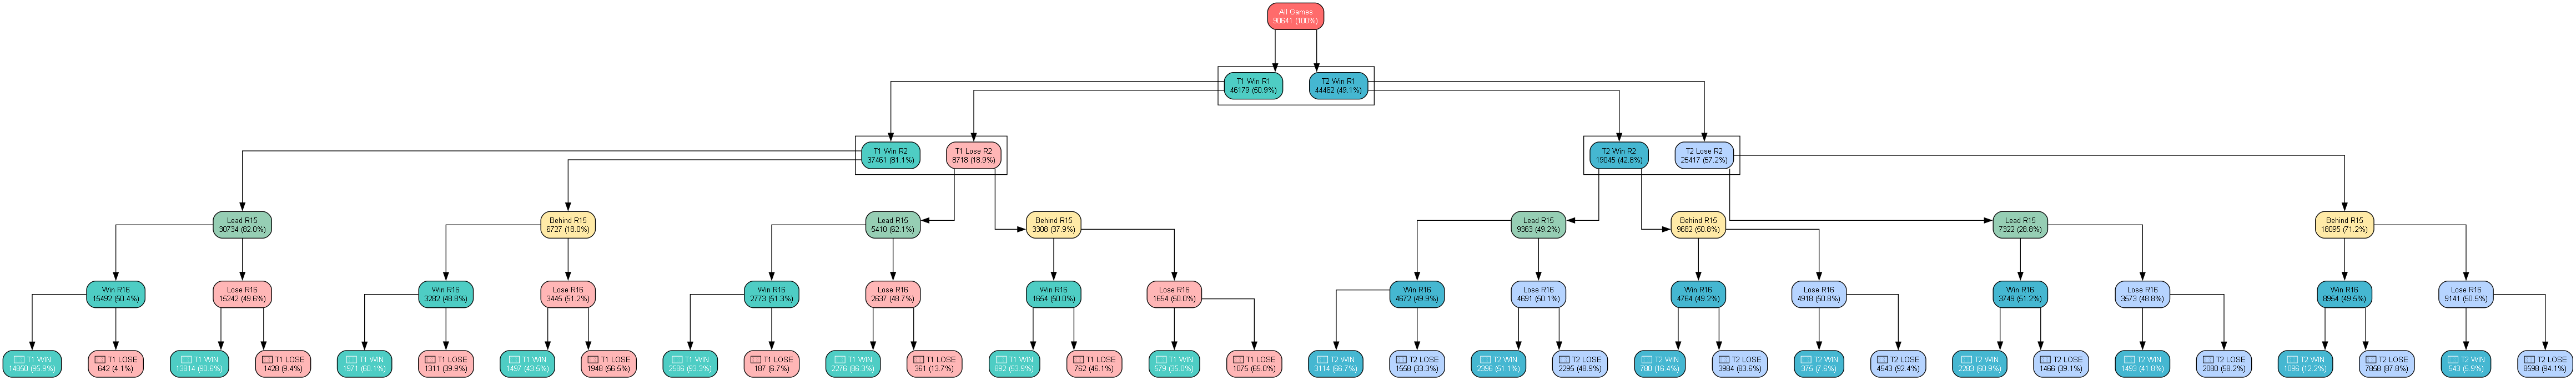

✓ Graphviz tree complete!


In [20]:
# ============================================================================
# GRAPHVIZ DIAGRAM - Professional hierarchical tree layout
# ============================================================================

from graphviz import Digraph

def create_graphviz_tree():
    """Create a Graphviz tree with proper hierarchical layout"""
    
    dot = Digraph(comment='CS:GO Game Progression', format='png')
    dot.attr(rankdir='TB', splines='ortho', nodesep='0.5', ranksep='0.8')
    dot.attr('node', shape='box', style='rounded,filled', fontname='Arial', fontsize='10')
    
    # Helper to format node label
    def make_label(label, count, parent_count=None):
        pct = f"{count/parent_count*100:.1f}%" if parent_count else "100%"
        return f"{label}\\n{count} ({pct})"
    
    # Root
    dot.node('root', make_label('All Games', total_games), fillcolor='#FF6B6B', fontcolor='white')
    
    # R1 level
    with dot.subgraph(name='cluster_r1') as c:
        c.attr(rank='same')
        c.node('t1r1', make_label('T1 Win R1', r1_counts['t1_wins'], total_games), fillcolor='#4ECDC4')
        c.node('t2r1', make_label('T2 Win R1', r1_counts['t2_wins'], total_games), fillcolor='#45B7D1')
    
    dot.edge('root', 't1r1')
    dot.edge('root', 't2r1')
    
    # R2 level - T1 path
    with dot.subgraph(name='cluster_t1r2') as c:
        c.attr(rank='same')
        c.node('t1r1_t1r2w', make_label('T1 Win R2', t1_r2_branches[0], r1_counts['t1_wins']), fillcolor='#4ECDC4')
        c.node('t1r1_t1r2l', make_label('T1 Lose R2', t1_r2_branches[1], r1_counts['t1_wins']), fillcolor='#FFB6B6')
    
    dot.edge('t1r1', 't1r1_t1r2w')
    dot.edge('t1r1', 't1r1_t1r2l')
    
    # R2 level - T2 path
    with dot.subgraph(name='cluster_t2r2') as c:
        c.attr(rank='same')
        c.node('t2r1_t2r2w', make_label('T2 Win R2', t2_r2_branches[0], r1_counts['t2_wins']), fillcolor='#45B7D1')
        c.node('t2r1_t2r2l', make_label('T2 Lose R2', t2_r2_branches[1], r1_counts['t2_wins']), fillcolor='#B6D4FF')
    
    dot.edge('t2r1', 't2r1_t2r2w')
    dot.edge('t2r1', 't2r1_t2r2l')
    
    # R15 level - T1 paths
    # T1 R2 win -> R15
    dot.node('t1r2w_lead', make_label('Lead R15', t1r1w_t1r2w_r15[0], t1_r2_branches[0]), fillcolor='#96CEB4')
    dot.node('t1r2w_behind', make_label('Behind R15', t1r1w_t1r2w_r15[1], t1_r2_branches[0]), fillcolor='#FFEAA7')
    dot.edge('t1r1_t1r2w', 't1r2w_lead')
    dot.edge('t1r1_t1r2w', 't1r2w_behind')
    
    # T1 R2 loss -> R15
    dot.node('t1r2l_lead', make_label('Lead R15', t1r1w_t1r2l_r15[0], t1_r2_branches[1]), fillcolor='#96CEB4')
    dot.node('t1r2l_behind', make_label('Behind R15', t1r1w_t1r2l_r15[1], t1_r2_branches[1]), fillcolor='#FFEAA7')
    dot.edge('t1r1_t1r2l', 't1r2l_lead')
    dot.edge('t1r1_t1r2l', 't1r2l_behind')
    
    # R15 level - T2 paths
    # T2 R2 win -> R15
    dot.node('t2r2w_lead', make_label('Lead R15', t2r1w_t2r2w_r15[0], t2_r2_branches[0]), fillcolor='#96CEB4')
    dot.node('t2r2w_behind', make_label('Behind R15', t2r1w_t2r2w_r15[1], t2_r2_branches[0]), fillcolor='#FFEAA7')
    dot.edge('t2r1_t2r2w', 't2r2w_lead')
    dot.edge('t2r1_t2r2w', 't2r2w_behind')
    
    # T2 R2 loss -> R15
    dot.node('t2r2l_lead', make_label('Lead R15', t2r1w_t2r2l_r15[0], t2_r2_branches[1]), fillcolor='#96CEB4')
    dot.node('t2r2l_behind', make_label('Behind R15', t2r1w_t2r2l_r15[1], t2_r2_branches[1]), fillcolor='#FFEAA7')
    dot.edge('t2r1_t2r2l', 't2r2l_lead')
    dot.edge('t2r1_t2r2l', 't2r2l_behind')
    
    # R16 level - T1 paths (simplified - showing only major branches)
    # For brevity, we'll show R16 outcomes without expanding all final outcomes
    r16_nodes_t1 = [
        ('t1r2w_lead', 't1_r2w_lead_r16w', 'Win R16', t1r1w_t1r2w_t1r15lead_r16[0], t1r1w_t1r2w_r15[0], '#4ECDC4'),
        ('t1r2w_lead', 't1_r2w_lead_r16l', 'Lose R16', t1r1w_t1r2w_t1r15lead_r16[1], t1r1w_t1r2w_r15[0], '#FFB6B6'),
        ('t1r2w_behind', 't1_r2w_behind_r16w', 'Win R16', t1r1w_t1r2w_t1r15behind_r16[0], t1r1w_t1r2w_r15[1], '#4ECDC4'),
        ('t1r2w_behind', 't1_r2w_behind_r16l', 'Lose R16', t1r1w_t1r2w_t1r15behind_r16[1], t1r1w_t1r2w_r15[1], '#FFB6B6'),
        ('t1r2l_lead', 't1_r2l_lead_r16w', 'Win R16', t1r1w_t1r2l_t1r15lead_r16[0], t1r1w_t1r2l_r15[0], '#4ECDC4'),
        ('t1r2l_lead', 't1_r2l_lead_r16l', 'Lose R16', t1r1w_t1r2l_t1r15lead_r16[1], t1r1w_t1r2l_r15[0], '#FFB6B6'),
        ('t1r2l_behind', 't1_r2l_behind_r16w', 'Win R16', t1r1w_t1r2l_t1r15behind_r16[0], t1r1w_t1r2l_r15[1], '#4ECDC4'),
        ('t1r2l_behind', 't1_r2l_behind_r16l', 'Lose R16', t1r1w_t1r2l_t1r15behind_r16[1], t1r1w_t1r2l_r15[1], '#FFB6B6'),
    ]
    
    for parent, node_id, label, count, parent_count, color in r16_nodes_t1:
        dot.node(node_id, make_label(label, count, parent_count), fillcolor=color)
        dot.edge(parent, node_id)
    
    # R16 level - T2 paths
    r16_nodes_t2 = [
        ('t2r2w_lead', 't2_r2w_lead_r16w', 'Win R16', t2r1w_t2r2w_t2r15lead_r16[0], t2r1w_t2r2w_r15[0], '#45B7D1'),
        ('t2r2w_lead', 't2_r2w_lead_r16l', 'Lose R16', t2r1w_t2r2w_t2r15lead_r16[1], t2r1w_t2r2w_r15[0], '#B6D4FF'),
        ('t2r2w_behind', 't2_r2w_behind_r16w', 'Win R16', t2r1w_t2r2w_t2r15behind_r16[0], t2r1w_t2r2w_r15[1], '#45B7D1'),
        ('t2r2w_behind', 't2_r2w_behind_r16l', 'Lose R16', t2r1w_t2r2w_t2r15behind_r16[1], t2r1w_t2r2w_r15[1], '#B6D4FF'),
        ('t2r2l_lead', 't2_r2l_lead_r16w', 'Win R16', t2r1w_t2r2l_t2r15lead_r16[0], t2r1w_t2r2l_r15[0], '#45B7D1'),
        ('t2r2l_lead', 't2_r2l_lead_r16l', 'Lose R16', t2r1w_t2r2l_t2r15lead_r16[1], t2r1w_t2r2l_r15[0], '#B6D4FF'),
        ('t2r2l_behind', 't2_r2l_behind_r16w', 'Win R16', t2r1w_t2r2l_t2r15behind_r16[0], t2r1w_t2r2l_r15[1], '#45B7D1'),
        ('t2r2l_behind', 't2_r2l_behind_r16l', 'Lose R16', t2r1w_t2r2l_t2r15behind_r16[1], t2r1w_t2r2l_r15[1], '#B6D4FF'),
    ]
    
    for parent, node_id, label, count, parent_count, color in r16_nodes_t2:
        dot.node(node_id, make_label(label, count, parent_count), fillcolor=color)
        dot.edge(parent, node_id)
    
    # Final outcomes - Add to R16 nodes
    final_data_t1 = [
        ('t1_r2w_lead_r16w', t1_final_counts['r2w_r15lead_r16w'], t1r1w_t1r2w_t1r15lead_r16[0]),
        ('t1_r2w_lead_r16l', t1_final_counts['r2w_r15lead_r16l'], t1r1w_t1r2w_t1r15lead_r16[1]),
        ('t1_r2w_behind_r16w', t1_final_counts['r2w_r15behind_r16w'], t1r1w_t1r2w_t1r15behind_r16[0]),
        ('t1_r2w_behind_r16l', t1_final_counts['r2w_r15behind_r16l'], t1r1w_t1r2w_t1r15behind_r16[1]),
        ('t1_r2l_lead_r16w', t1_final_counts['r2l_r15lead_r16w'], t1r1w_t1r2l_t1r15lead_r16[0]),
        ('t1_r2l_lead_r16l', t1_final_counts['r2l_r15lead_r16l'], t1r1w_t1r2l_t1r15lead_r16[1]),
        ('t1_r2l_behind_r16w', t1_final_counts['r2l_r15behind_r16w'], t1r1w_t1r2l_t1r15behind_r16[0]),
        ('t1_r2l_behind_r16l', t1_final_counts['r2l_r15behind_r16l'], t1r1w_t1r2l_t1r15behind_r16[1]),
    ]
    
    idx = 0
    for parent, (wins, losses), parent_count in final_data_t1:
        dot.node(f't1_final_w_{idx}', make_label('✓ T1 WIN', wins, parent_count), fillcolor='#4ECDC4', fontcolor='white')
        dot.node(f't1_final_l_{idx}', make_label('✗ T1 LOSE', losses, parent_count), fillcolor='#FFB6B6')
        dot.edge(parent, f't1_final_w_{idx}')
        dot.edge(parent, f't1_final_l_{idx}')
        idx += 1
    
    final_data_t2 = [
        ('t2_r2w_lead_r16w', t2_final_counts['r2w_r15lead_r16w'], t2r1w_t2r2w_t2r15lead_r16[0]),
        ('t2_r2w_lead_r16l', t2_final_counts['r2w_r15lead_r16l'], t2r1w_t2r2w_t2r15lead_r16[1]),
        ('t2_r2w_behind_r16w', t2_final_counts['r2w_r15behind_r16w'], t2r1w_t2r2w_t2r15behind_r16[0]),
        ('t2_r2w_behind_r16l', t2_final_counts['r2w_r15behind_r16l'], t2r1w_t2r2w_t2r15behind_r16[1]),
        ('t2_r2l_lead_r16w', t2_final_counts['r2l_r15lead_r16w'], t2r1w_t2r2l_t2r15lead_r16[0]),
        ('t2_r2l_lead_r16l', t2_final_counts['r2l_r15lead_r16l'], t2r1w_t2r2l_t2r15lead_r16[1]),
        ('t2_r2l_behind_r16w', t2_final_counts['r2l_r15behind_r16w'], t2r1w_t2r2l_t2r15behind_r16[0]),
        ('t2_r2l_behind_r16l', t2_final_counts['r2l_r15behind_r16l'], t2r1w_t2r2l_t2r15behind_r16[1]),
    ]
    
    idx = 0
    for parent, (wins, losses), parent_count in final_data_t2:
        dot.node(f't2_final_w_{idx}', make_label('✓ T2 WIN', wins, parent_count), fillcolor='#45B7D1', fontcolor='white')
        dot.node(f't2_final_l_{idx}', make_label('✗ T2 LOSE', losses, parent_count), fillcolor='#B6D4FF')
        dot.edge(parent, f't2_final_w_{idx}')
        dot.edge(parent, f't2_final_l_{idx}')
        idx += 1
    
    return dot

# Create and render Graphviz tree
print("Building Graphviz tree...")
dot = create_graphviz_tree()

# Display the graph
from IPython.display import Image, display
display(Image(dot.pipe(format='png')))

print("✓ Graphviz tree complete!")

# Optionally save to file
# dot.render('csgo_game_tree', format='png', cleanup=True)
# print("  Saved to: csgo_game_tree.png")

In [21]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.patches as mpatches

# Create a directed graph
G = nx.DiGraph()

# Define nodes with labels showing count and percentage
nodes_data = [
    ("All", f"All Games\n{total}", 0),
    ("P1", f"Win Pistol 1\n{n1} ({n1/total*100:.1f}%)", 1),
    ("R2", f"Win Round 2\n{n2} ({n2/n1*100 if n1 else 0:.1f}%)", 2),
    ("FH", f"Win More\n1st Half\n{n3} ({n3/n2*100 if n2 else 0:.1f}%)", 3),
    ("P2", f"Win Pistol 2\n{n4} ({n4/n3*100 if n3 else 0:.1f}%)", 4),
    ("R17", f"Reach R17\n{n4_r17_exist} ({n4_r17_exist/n4*100 if n4 else 0:.1f}%)", 5),
    ("R17W", f"Win Round 17\n{n5} ({n5/n4_r17_exist*100 if n4_r17_exist else 0:.1f}%)", 6),
    ("SH", f"Win More\n2nd Half\n{n6} ({n6/n5*100 if n5 else 0:.1f}%)", 7),
]

# Add nodes
for node_id, label, _ in nodes_data:
    G.add_node(node_id, label=label)

# Add edges
edges = [
    ("All", "P1"),
    ("P1", "R2"),
    ("R2", "FH"),
    ("FH", "P2"),
    ("P2", "R17"),
    ("R17", "R17W"),
    ("R17W", "SH"),
]

G.add_edges_from(edges)

# Create the visualization
plt.figure(figsize=(16, 10))

# Use a hierarchical layout
pos = {}
levels = {
    "All": 0,
    "P1": 1,
    "R2": 2,
    "FH": 3,
    "P2": 4,
    "R17": 5,
    "R17W": 6,
    "SH": 7,
}

# Manually position nodes in a tree-like structure
y_spacing = 1.5
for node, level in levels.items():
    pos[node] = (level * 2, -level * y_spacing)

# Draw the network
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, arrowstyle='->', width=2, 
                       connectionstyle="arc3,rad=0", ax=plt.gca())

# Draw nodes with colors
node_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DFE6E9', '#A29BFE', '#74B9FF']
node_color_list = [node_colors[i] for i in range(len(nodes_data))]

nx.draw_networkx_nodes(G, pos, node_color=node_color_list, node_size=3000, 
                       node_shape='o', ax=plt.gca(), edgecolors='black', linewidths=2)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={node: label for node, label, _ in nodes_data},
                       font_size=9, font_weight='bold', ax=plt.gca())

plt.title("Team 1 Path to Victory - Decision Tree\n(Counts and % of Previous Stage)", 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("TREE STATISTICS")
print("="*60)
print(f"Win Rate at Each Stage (% of previous stage):")
print(f"  Pistol 1 (R1): {n1/total*100:.2f}%")
print(f"  Round 2 (R2):  {n2/n1*100 if n1 else 0:.2f}%")
print(f"  1st Half:      {n3/n2*100 if n2 else 0:.2f}%")
print(f"  Pistol 2 (R16):{n4/n3*100 if n3 else 0:.2f}%")
print(f"  Reach R17:     {n4_r17_exist/n4*100 if n4 else 0:.2f}%")
print(f"  Round 17 (R17):{n5/n4_r17_exist*100 if n4_r17_exist else 0:.2f}%")
print(f"  2nd Half:      {n6/n5*100 if n5 else 0:.2f}%")
print("="*60)

NameError: name 'total' is not defined

### amount of reversals per game. average duration of a streak

### spenditure per win (?)

## Calculate the amount of streaks and compare them to other simulated games and to real games. 

In [ ]:
# Filter rows where consecutive losses are 0, and round number is neither > 2 nor 16 or 17
t1_winner_streak_reversal_data = df_filtered[
    (df_filtered['t1_consecutive_losses'] == 0) & 
    (df_filtered['t2_consecutive_losses'] == 1) & 
    (~df_filtered['round_number'].isin([1,  16 ]))
]

# Add rows where t1_consecutive_losses is 1 and t2_consecutive_losses is 0, excluding specific rounds
t2_winner_streak_reversal_data = df_filtered[
    (df_filtered['t1_consecutive_losses'] == 1) & 
    (df_filtered['t2_consecutive_losses'] == 0) & 
    (~df_filtered['round_number'].isin([1,  16 ]))
]

# Combine the filtered data
filtered_data = pd.concat([t1_winner_streak_reversal_data, t2_winner_streak_reversal_data], ignore_index=True)

print(f"Filtered rows: {len(filtered_data)}")
filtered_data

Filtered rows: 645063


,round_number,is_t1_winner,is_t1_ct,is_ot,outcome_reason_code,outcome_bomb_planted,t1_score_start,t1_score_end,t1_spent,t1_earned,...,t2_funds_start,t2_rs_eq,t2_fte_eq,t2_re_eq,t2_survivors,t2_consecutive_losses,t2_consecutive_wins,t2_loss_bonus_level,game_id,is_pistol_round
0,5,True,False,False,2,True,2,3,14700.0,18050.0,...,61000.0,4190.0,4190.0,0.0,0,1,0,2,sim_1_20251222_111451_DPE1-2_1623,False
1,10,True,False,False,2,True,5,6,10400.0,18050.0,...,37050.0,11034.0,48084.0,0.0,0,1,0,3,sim_1_20251222_111451_DPE1-2_1623,False
2,2,True,False,False,2,False,0,1,14400.0,17750.0,...,19300.0,4135.0,23435.0,0.0,0,1,0,1,sim_2_20251222_111451_DPE1-2_2024,False
3,10,True,False,False,1,True,5,6,17200.0,18400.0,...,36750.0,6029.0,6029.0,6738.0,3,1,0,2,sim_2_20251222_111451_DPE1-2_2024,False
4,15,True,False,False,2,True,9,10,11600.0,18050.0,...,19300.0,20506.0,39806.0,0.0,0,1,0,4,sim_2_20251222_111451_DPE1-2_2024,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645058,2,False,True,False,1,True,1,1,19000.0,8500.0,...,15000.0,1600.0,16600.0,0.0,0,0,1,1,sim_99813_20251222_111452_DPE1-2_9118,False
645059,9,False,True,False,2,True,7,7,17750.0,7600.0,...,51600.0,1000.0,52600.0,45168.0,3,0,1,3,sim_99813_20251222_111452_DPE1-2_9118,False
645060,13,False,True,False,1,True,8,8,17750.0,12300.0,...,28450.0,1000.0,29450.0,23644.0,4,0,1,1,sim_99813_20251222_111452_DPE1-2_9118,False
645061,17,False,False,False,4,False,9,9,19300.0,15400.0,...,12200.0,1000.0,13200.0,9342.0,2,0,1,0,sim_99813_20251222_111452_DPE1-2_9118,False
